# Introducción a la librería *JAX*

## Por: **Hugo Peralta Muñoz**

Este proyecto consiste en tratar de explicar varias características que tiene la librería *JAX*, el objetivo será realizar una introducción práctica a la librería para la computación numérica y machine learning mediante la incorporación de **FLAX**.

Información sacada de las páginas oficiales de las dependencias:

[QuickStart with JAX](https://jax.readthedocs.io/en/latest/quickstart.html)  

[JAX Characteristics](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html)  

[FLAX Basics](https://flax.readthedocs.io/en/latest/nnx_basics.html)  

[FLAX Mnist Tutorial](https://flax.readthedocs.io/en/latest/mnist_tutorial.html)  


**Características**:

- JAX ofrece una interfaz unificada similar a NumPy para realizar cálculos en CPU, GPU o TPU, tanto de forma local como en entornos distribuidos.

- Incluye compilación Just-In-Time (JIT) integrada a través de Open XLA, un ecosistema de código abierto para la compilación de modelos de aprendizaje automático.

- Sus funciones permiten una evaluación eficiente de gradientes mediante transformaciones de diferenciación automática.

- Además, JAX puede vectorizar funciones automáticamente para procesar de manera optimizada conjuntos de datos en lotes.

## Importación de librerías

In [411]:
import numpy as np
import matplotlib.pyplot as plt
import time
import timeit
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

# Librerias de TensorFlow   
import tensorflow as tf
import tensorflow_datasets as tfds

# Librerias de PyTorch
import torch

# Librerias que usaremos con jax
import jax
import jax.numpy as jnp
from jax import jit, grad, vmap, random
from flax import nnx
from functools import partial 
import optax

## Conceptos básicos y diferenciación con NumPy

El *JIT* (Just-In-Time) de **JAX** optimiza el rendimiento de aquellas funciones que sean inamovibles, compilándolas con XLA antes de su ejecución. Esto permite que el código se ejecute mucho más rápido, especialmente en GPU y TPU.

*JIT* reduce el tiempo de ejecución tras la primera llamada, ya que compila y optimiza la función para las siguientes ejecuciones.

In [412]:
def slow_function(x):
    return jnp.sin(x) + jnp.cos(x)

jit_function = jit(slow_function)

x = jnp.linspace(0, 10, 1000)

print(jit_function(x))  

[ 1.00000000e+00  1.00995970e+00  1.01981831e+00  1.02957463e+00
  1.03922784e+00  1.04877687e+00  1.05822086e+00  1.06755877e+00
  1.07678986e+00  1.08591294e+00  1.09492719e+00  1.10383177e+00
  1.11262572e+00  1.12130821e+00  1.12987828e+00  1.13833523e+00
  1.14667809e+00  1.15490603e+00  1.16301823e+00  1.17101395e+00
  1.17889237e+00  1.18665254e+00  1.19429386e+00  1.20181561e+00
  1.20921683e+00  1.21649694e+00  1.22365510e+00  1.23069072e+00
  1.23760295e+00  1.24439120e+00  1.25105476e+00  1.25759304e+00
  1.26400518e+00  1.27029073e+00  1.27644908e+00  1.28247941e+00
  1.28838122e+00  1.29415405e+00  1.29979718e+00  1.30531001e+00
  1.31069207e+00  1.31594276e+00  1.32106173e+00  1.32604825e+00
  1.33090186e+00  1.33562219e+00  1.34020865e+00  1.34466076e+00
  1.34897828e+00  1.35316050e+00  1.35720730e+00  1.36111784e+00
  1.36489224e+00  1.36852980e+00  1.37203014e+00  1.37539315e+00
  1.37861824e+00  1.38170528e+00  1.38465381e+00  1.38746357e+00
  1.39013433e+00  1.39266

✅ Ventaja: De esta forma, la primera ejecución de esta función la compilarará y tardará lo mismo, pero lograremos que para las próximas ejecuciones sea mucho más rápidas.

Además de transformar funciones mediante compilación *JIT*, **JAX** también ofrece otras transformaciones. Una de ellas es `jax.grad()`, que realiza diferenciación automática (*autodiff*):

In [413]:
# Función simple: f(x) = x^2
def f(x):
    return x**2

# Derivada de f(x)
dfdx = grad(f)

x = 3.0
print(dfdx(x))

6.0


✅ Ventaja: Calcula derivadas sin necesidad de hacerlo manualmente. Útil en optimización y deep learning.

Otra transformación útil es `vmap()`, el mapa vectorizador. Tiene la misma semántica familiar de aplicar una función a lo largo de los ejes de un arreglo, pero en lugar de usar bucles explícitos en las llamadas a la función, transforma la función en una versión vectorizada de forma nativa para mejorar el rendimiento. Cuando se combina con `jit()`, puede ser tan eficiente como reescribir manualmente la función para operar sobre una dimension extra de lotes.

In [414]:
# Función escalar
def square(x):
    return x**2

# Vectorización automática
vectorized_square = vmap(square)

x = jnp.array([1, 2, 3, 4])
print(vectorized_square(x))

[ 1  4  9 16]


✅ Ventaja: Es más eficiente que un `for` en grandes lotes de datos porque evita bucles explícitos y usa paralelización optimizada.

### Entradas no-arrays

NumPy generalmente acepta listas o tuplas de Python como entradas para sus funciones de la API:

In [415]:
np.sum([1, 2, 3])

6

Por otro lado, JAX se comporta de manera diferente, generalmente devolviendo un error informativo cuando se le pasan listas o tuplas:

### **IMPORTANTE: DESCOMENTAR LA CELDA INFERIOR PARA OBSERVAR EL ERROR QUE MUESTRA**

In [416]:
# jnp.sum([1, 2, 3])

Esto se debe a que **JAX** está diseñado para trabajar principalmente con ndarray de **JAX** (`jnp.array`) o con escalares, lo que fomenta un uso más consistente y optimizado para sus operaciones, especialmente cuando se utiliza en hardware como GPU o TPU.

### Prueba de rendimiento: JAX vs NumPY

In [417]:
# Crearemos un conjunto de numeros aleatorios
data_random_np = np.random.rand(10**7)
data_random_jax = jnp.array(np.random.rand(10**7))
print(data_random_np, data_random_jax)

[0.56964891 0.04919198 0.58264874 ... 0.01309426 0.90694236 0.69590355] [0.9161681  0.71131045 0.31821293 ... 0.25303075 0.28957283 0.7566489 ]


#### Suma de los cuadrados en NumPy

In [418]:
execution_time_np = timeit.timeit(lambda: np.sum(data_random_np**2), number=1)
print(f"NumPy - Tiempo de ejecución: {execution_time_np:.10f} segundos")

NumPy - Tiempo de ejecución: 0.0552798000 segundos


#### Suma de los cuadrados en JAX (Sin JIT)

In [419]:
execution_time_jax = timeit.timeit(lambda: jnp.sum(data_random_jax**2), number=1)
print(f"JAX (sin JIT) - Tiempo de ejecución: {execution_time_jax:.10f} segundos")

JAX (sin JIT) - Tiempo de ejecución: 0.0046741000 segundos


#### Suma de los cuadrados en JAX (Con JIT)

In [420]:
@jit
def sum_of_squares(x):
    return jnp.sum(x**2)

# Primer llamada para compilar (no se mide el tiempo real)
_ = sum_of_squares(data_random_jax)

execution_time_jax_jit = timeit.timeit(lambda: sum_of_squares(data_random_jax), number=1)
print(f"JAX (con JIT) - Tiempo de ejecución: {execution_time_jax_jit:.10f} segundos")

JAX (con JIT) - Tiempo de ejecución: 0.0001335000 segundos


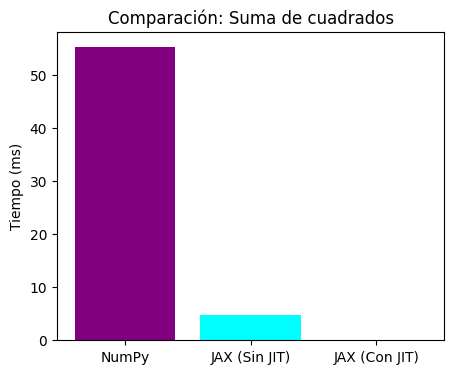

In [421]:
labels = ["NumPy", "JAX (Sin JIT)", "JAX (Con JIT)"]
times = [execution_time_np * 1000, execution_time_jax * 1000, execution_time_jax_jit * 1000]

plt.figure(figsize=(5, 4))
plt.bar(labels, times, color=["purple", "cyan", "green"])
plt.ylabel("Tiempo (ms)")
plt.title("Comparación: Suma de cuadrados")
plt.show()

## Implementación de Jax para Redes Neuronales. **FLAX**.

Flax es una biblioteca que proporciona una experiencia de usuario flexible y completa para investigadores y desarrolladores que utilizan JAX en redes neuronales. Gracias a Flax, puedes aprovechar al máximo el poder de JAX, facilitando la creación, inspección, depuración y análisis de redes neuronales.

En el núcleo de Flax se encuentra **NNX** (*Neural Network for FlaX*), una API simplificada que hace mucho más fácil trabajar con modelos en JAX. Flax NNX ofrece un soporte de primera clase para las referencias en Python, lo que permite a los usuarios expresar sus modelos utilizando objetos regulares de Python. Esta API es una evolución de la anterior API Flax Linen, y ha sido diseñada tras años de experiencia para ofrecer una interfaz más sencilla y amigable.

## Características

* Código Pythonic: Flax NNX admite el uso de objetos regulares de Python, proporcionando una experiencia de desarrollo intuitiva y predecible.
* Sencillo: Flax NNX se basa en el modelo de objetos de Python, lo que resulta en simplicidad para el usuario y acelera el proceso de desarrollo.
* Expresivo: Flax NNX permite un control detallado del estado del modelo a través de su sistema de Filtros.
* Familiar: Flax NNX facilita la integración de objetos con el código regular de JAX mediante la API Funcional.

### Vamos a realizar el ejemplo de creación de un modelo sencillo de CNN.

Ejemplo sacado de la guía oficial de introducción de **FLAX**: 
 
[MNIST Tutorial Flax](https://flax.readthedocs.io/en/latest/mnist_tutorial.html)

In [422]:
# Establecer la semilla para garantizar la reproducibilidad.
tf.random.set_seed(0)

# Parámetros de entrenamiento.
train_steps = 1200
batch_size = 32

# Cargar los conjuntos de datos de entrenamiento y prueba.
train_ds = tfds.load('mnist', split='train')
test_ds  = tfds.load('mnist', split='test')

# Función para normalizar las imágenes.
def normalizar(sample):
    return {
        'image': tf.cast(sample['image'], tf.float32) / 255,  # Convertir a float32 y escalar a [0, 1].
        'label': sample['label']
    }

# Aplicar la normalización a ambos conjuntos.
train_ds = train_ds.map(normalizar)
test_ds  = test_ds.map(normalizar)

# Preparar el conjunto de entrenamiento:
# - Repetir el dataset indefinidamente.
# - Mezclar con un buffer de 1024 elementos.
# - Agrupar en lotes (batch) de tamaño 32, descartando lotes incompletos.
# - Tomar únicamente 'train_steps' lotes.
# - Prefetch para mejorar la latencia.
train_ds = train_ds.repeat().shuffle(1024).batch(batch_size, drop_remainder=True).take(train_steps).prefetch(1)

# Preparar el conjunto de prueba agrupando en lotes y usando prefetch.
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)


In [423]:
# Definición de un modelo CNN simple.
class CNN(nnx.Module):
    """Un modelo CNN simple."""

    def __init__(self, *, rngs: nnx.Rngs):
        # Capa convolucional: de 1 canal a 32 canales con kernel 3x3.
        self.conv1 = nnx.Conv(1, 32, kernel_size=(3, 3), rngs=rngs)
        # Segunda capa convolucional: de 32 a 64 canales con kernel 3x3.
        self.conv2 = nnx.Conv(32, 64, kernel_size=(3, 3), rngs=rngs)
        # Función de pooling promedio con ventana de 2x2 y stride de 2x2.
        self.avg_pool = partial(nnx.avg_pool, window_shape=(2, 2), strides=(2, 2))
        # Capa lineal que transforma la entrada a 256 dimensiones.
        self.linear1 = nnx.Linear(3136, 256, rngs=rngs)
        # Capa de salida lineal con 10 unidades (por ejemplo, para 10 clases).
        self.linear2 = nnx.Linear(256, 10, rngs=rngs)

    def __call__(self, x):
        # Aplicar la primera convolución seguida de activación ReLU y pooling.
        x = self.avg_pool(nnx.relu(self.conv1(x)))
        # Aplicar la segunda convolución seguida de activación ReLU y pooling.
        x = self.avg_pool(nnx.relu(self.conv2(x)))
        # Aplanar la salida para pasarla a las capas lineales.
        x = x.reshape(x.shape[0], -1)
        # Aplicar la primera capa lineal con activación ReLU.
        x = nnx.relu(self.linear1(x))
        # Aplicar la capa de salida.
        x = self.linear2(x)
        return x

# Instanciar el modelo utilizando una semilla.
model = CNN(rngs=nnx.Rngs(0))

# Visualizar la estructura del modelo.
nnx.display(model)

CNN(
  conv1=Conv(
    kernel_shape=(3, 3, 1, 32),
    kernel=Param(
      value=Array(shape=(3, 3, 1, 32), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(32,), dtype=float32)
    ),
    in_features=1,
    out_features=32,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',
    input_dilation=1,
    kernel_dilation=1,
    feature_group_count=1,
    use_bias=True,
    mask=None,
    dtype=None,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    kernel_init=<function variance_scaling.<locals>.init at 0x000002781AFC9580>,
    bias_init=<function zeros at 0x00000278778ED9E0>,
    conv_general_dilated=<function conv_general_dilated at 0x0000027877463880>
  ),
  conv2=Conv(
    kernel_shape=(3, 3, 32, 64),
    kernel=Param(
      value=Array(shape=(3, 3, 32, 64), dtype=float32)
    ),
    bias=Param(
      value=Array(shape=(64,), dtype=float32)
    ),
    in_features=32,
    out_features=64,
    kernel_size=(3, 3),
    strides=1,
    padding='SAME',


In [424]:
# Probar el modelo con una entrada de ejemplo:
# Un batch de 1 imagen de 28x28 píxeles con 1 canal.
y = model(jnp.ones((1, 28, 28, 1)))
print(y)

[[ 0.18405598  0.50485927  0.2009596   0.4873969  -0.37915212 -0.5551914
  -0.54481304 -0.04560151  0.05879337  0.13339703]]


## Prueba de rendimiento: JAX vs PyTorch vs TensorFlow

Primero de todo, cargaremos un dataset original y lo trataremos para usarlo con las distintas librerías.

En este caso usaremos el dataset de *California Housing* con el cual crearemos un modelo muy sencillo de *Regresión Lineal*.

In [425]:
# Cargar el dataset
data = fetch_california_housing()
X, y = data.data, data.target

# Normalizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convertir el target a formato columna (para realizar la regresion)
y = y.reshape(-1, 1).astype(np.float32)

# Convertir a float32 para compatibilidad con JAX, PyTorch y TensorFlow
X = X.astype(np.float32)
y = y.astype(np.float32)

### JAX

En este caso podríamos usar mas opciones que nos ofrece **Flax** como la etiqueta de método `@nnx.jit` para la optimización del caso de `train_step()`, pero como quiero hacer más profundidad en **JAX** intentaremos implementar lo que podamos desde esta librería.

In [426]:
# Inicializar pesos y bias aleatoriamente
key = random.PRNGKey(0)
w = random.normal(key, (X.shape[1], 1)) * 0.01
b = jnp.zeros((1,))

In [427]:
# Definir modelo y pérdida para optimizar con JIT
def predict(w, b, x):
    return jnp.dot(x, w) + b

def loss_fn(w, b, x, y):
    preds = predict(w, b, x)
    return jnp.mean(jnp.square(preds - y))

In [428]:
# Optimización con JIT
optimizer = optax.sgd(learning_rate=0.01)
opt_state = optimizer.init((w, b))

@jax.jit
def train_step(w, b, opt_state, x, y):
    def loss_closure(params):
        w, b = params
        return loss_fn(w, b, x, y)
    loss, grads = jax.value_and_grad(loss_closure)((w, b))
    updates, opt_state = optimizer.update(grads, opt_state)
    w, b = optax.apply_updates((w, b), updates)
    return w, b, opt_state, loss

In [429]:
# Entrenamiento
X_jax, y_jax = jnp.array(X), jnp.array(y)
epochs = 1000
start_time_jax = time.time()

for _ in range(epochs):
    w, b, opt_state, loss = train_step(w, b, opt_state, X_jax, y_jax)

jax_time = time.time() - start_time_jax
preds_jax = np.array(predict(w, b, X_jax))

print(f"Flax (JAX) - Tiempo de entrenamiento: {jax_time:.6f} segundos")

Flax (JAX) - Tiempo de entrenamiento: 0.145992 segundos


### PyTorch

In [430]:
# Inicializar pesos y bias
w = torch.randn(X.shape[1], 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)
optimizer = torch.optim.SGD([w, b], lr=0.01)

In [431]:
# Función de predicción y pérdida
def predict(x):
    return x @ w + b

loss_fn = torch.nn.MSELoss()

In [432]:
# Entrenamiento
X_torch, y_torch = torch.tensor(X), torch.tensor(y)
epochs = 1000
start_time = time.time()

for _ in range(epochs):
    optimizer.zero_grad()
    loss = loss_fn(predict(X_torch), y_torch)
    loss.backward()
    optimizer.step()

torch_time = time.time() - start_time
preds_pytorch = (X_torch @ w + b).detach().numpy()

print(f"PyTorch - Tiempo de entrenamiento: {torch_time:.6f} segundos")

PyTorch - Tiempo de entrenamiento: 0.607580 segundos


### TensorFlow

In [433]:
# Inicializar pesos y bias
w = tf.Variable(tf.random.normal([X.shape[1], 1]), trainable=True)
b = tf.Variable(tf.zeros([1]), trainable=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

In [434]:
# Entrenamiento
X_tf, y_tf = tf.convert_to_tensor(X), tf.convert_to_tensor(y)
epochs = 1000
start_time = time.time()

for _ in range(epochs):
    with tf.GradientTape() as tape:
        preds = tf.matmul(X_tf, w) + b
        loss = loss_fn(y_tf, preds)
    grads = tape.gradient(loss, [w, b])
    optimizer.apply_gradients(zip(grads, [w, b]))

tf_time = time.time() - start_time
preds_tensorflow = (tf.matmul(X_tf, w) + b).numpy()

print(f"TensorFlow - Tiempo de entrenamiento: {tf_time:.6f} segundos")

TensorFlow - Tiempo de entrenamiento: 7.652259 segundos


## Gráfico de comparativa con **MSE (*Mean Squared Error*)**

MSE JAX: 0.530947
MSE PyTorch: 0.536079
MSE TensorFlow: 0.533306


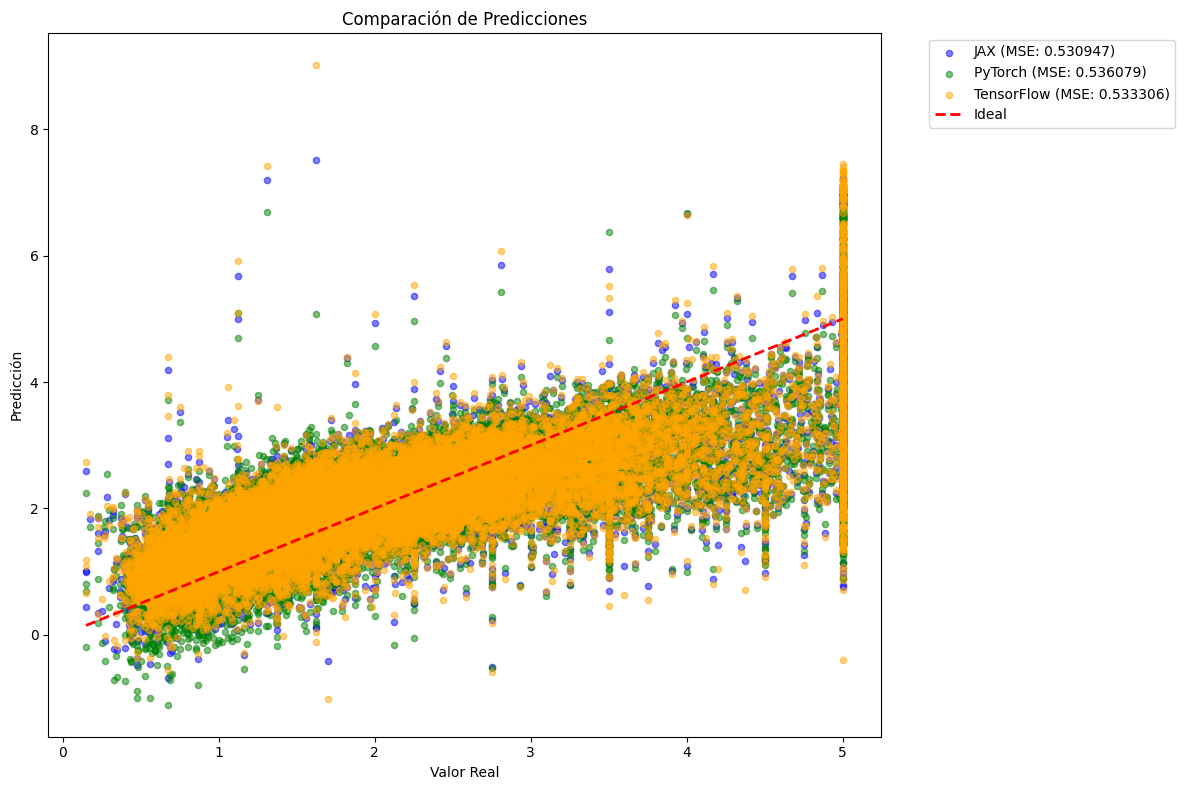

In [435]:
# Calcular el error cuadrático medio (MSE) para cada framework
mse_jax = mean_squared_error(y, preds_jax)
mse_torch = mean_squared_error(y, preds_pytorch)
mse_tf = mean_squared_error(y, preds_tensorflow)

print(f"MSE JAX: {mse_jax:.6f}")
print(f"MSE PyTorch: {mse_torch:.6f}")
print(f"MSE TensorFlow: {mse_tf:.6f}")

# Crear un gráfico conjunto: scatter plot de predicciones vs. valores reales
plt.figure(figsize=(12, 8))
plt.scatter(y, preds_jax, alpha=0.5, label=f'JAX (MSE: {mse_jax:.6f})', color='blue', s=20)
plt.scatter(y, preds_pytorch, alpha=0.5, label=f'PyTorch (MSE: {mse_torch:.6f})', color='green', s=20)
plt.scatter(y, preds_tensorflow, alpha=0.5, label=f'TensorFlow (MSE: {mse_tf:.6f})', color='orange', s=20)

# Línea ideal
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal', linewidth=2)

plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Comparación de Predicciones')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Conclusión

Podemos ver a continuación que JAX rivaliza en gran medida con librerías como son PyTorch y TensorFlow, las cuales llevan mucho tiempo en el mercado.

En resumen, esta herramienta es bastante poderosa y de optimizarse de mejor manera con las capacidades que tiene **FLAX**, la librería que se especializa en *Redes Neuronales* diseñada con **JAX** de base, se puede posicionar como una alternativa competitiva a la par de *PyTorch* y de *TensorFlow* para el aprendizaje automático. 